In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [96]:
model_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240314/BUFF/BUFF_loss_0.19692087173461914_ml_output_BUFF.parquet"

In [97]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [98]:
df

,target_error_lead_0,Model forecast,diff
0,0.048846,-0.246395,0.295241
1,0.618327,0.060095,0.558232
2,-0.563166,-0.258188,-0.304978
3,-0.540142,0.056524,-0.596665
4,0.006308,-0.088056,0.094363
...,...,...,...
7555,0.622094,0.124461,0.497633
7556,0.083469,0.143199,-0.059730
7557,0.268127,0.350015,-0.081888
7558,0.132208,0.116112,0.016096


In [99]:
# rnn_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/RNN/BUFF_loss_0.3963880025678211_ml_output_BUFF.parquet"
# rnn_df = pd.read_parquet(rnn_path)
# rnn_df = rnn_df.sort_index()

In [100]:
# rnn_df

In [101]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240314/BUFF/03_14_2024_14:40:44_full_BUFF.parquet"
)

In [102]:
for k in full_df.keys():
    print(k)

t2m_BUFF
valid_time_cos
valid_time_sin
target_error
sh2_BUFF
d2m_BUFF
r2_BUFF
u10_BUFF
v10_BUFF
u_total_BUFF
u_dir_BUFF
tp_BUFF
prmsl_BUFF
orog_BUFF
tcc_BUFF
cape_BUFF
cin_BUFF
dswrf_BUFF
dlwrf_BUFF
gh_BUFF
valid_time
t2m_LOUI
sh2_LOUI
d2m_LOUI
r2_LOUI
u10_LOUI
v10_LOUI
u_total_LOUI
u_dir_LOUI
tp_LOUI
prmsl_LOUI
orog_LOUI
tcc_LOUI
cape_LOUI
cin_LOUI
dswrf_LOUI
dlwrf_LOUI
gh_LOUI
t2m_GABR
sh2_GABR
d2m_GABR
r2_GABR
u10_GABR
v10_GABR
u_total_GABR
u_dir_GABR
tp_GABR
prmsl_GABR
orog_GABR
tcc_GABR
cape_GABR
cin_GABR
dswrf_GABR
dlwrf_GABR
gh_GABR
t2m_CHES
sh2_CHES
d2m_CHES
r2_CHES
u10_CHES
v10_CHES
u_total_CHES
u_dir_CHES
tp_CHES
prmsl_CHES
orog_CHES
tcc_CHES
cape_CHES
cin_CHES
dswrf_CHES
dlwrf_CHES
gh_CHES
lat_BUFF
lon_BUFF
elev_BUFF
tair_BUFF
ta9m_BUFF
td_BUFF
relh_BUFF
srad_BUFF
pres_BUFF
mslp_BUFF
wspd_sonic_BUFF
wmax_sonic_BUFF
wdir_sonic_BUFF
precip_total_BUFF
snow_depth_BUFF
lat_LOUI
lon_LOUI
elev_LOUI
tair_LOUI
ta9m_LOUI
td_LOUI
relh_LOUI
srad_LOUI
pres_LOUI
mslp_LOUI
wspd_sonic_LOUI


In [103]:
df["valid_time"] = full_df["valid_time"]
# df['rnn_err'] = rnn_df['diff']

In [104]:
df

,target_error_lead_0,Model forecast,diff,valid_time
0,0.048846,-0.246395,0.295241,2018-01-01 03:00:00
1,0.618327,0.060095,0.558232,2018-01-01 09:00:00
2,-0.563166,-0.258188,-0.304978,2018-01-01 15:00:00
3,-0.540142,0.056524,-0.596665,2018-01-01 21:00:00
4,0.006308,-0.088056,0.094363,2018-01-02 03:00:00
...,...,...,...,...
7555,0.622094,0.124461,0.497633,2023-12-30 21:00:00
7556,0.083469,0.143199,-0.059730,2023-12-31 03:00:00
7557,0.268127,0.350015,-0.081888,2023-12-31 09:00:00
7558,0.132208,0.116112,0.016096,2023-12-31 15:00:00


In [105]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [106]:
station = "BUFF"

In [107]:
df['valid_time'] = pd.to_datetime(df['valid_time'])

In [108]:
df['valid_time'].dtype

dtype('<M8[ns]')

In [109]:
df['valid_time'].dt.hour

0        3
1        9
2       15
3       21
4        3
        ..
7555    21
7556     3
7557     9
7558    15
7559    21
Name: valid_time, Length: 7560, dtype: int64

In [110]:
df_train, df_test = which_fold(df, 4)

In [111]:
df_test.iloc[0]

Timestamp('2022-08-25 15:00:00')

In [112]:
df_test.iloc[-1]

Timestamp('2023-12-31 21:00:00')

In [113]:
df = df[df['valid_time'] > datetime(2022, 8, 6, 0, 0, 0)]
df = df[df['valid_time'] < datetime(2023, 12, 31, 23, 0, 0)]

In [114]:
import matplotlib.dates as mdates

In [115]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def ml_output(df, fold, station):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (x.dt.hour < 18)  # Adjust the hours based on your day/night definition

    plt.plot(x, df["target_error_lead_0"], c="r", linewidth=3, label="2MT Error: HRRR")
    plt.plot(x, df["Model forecast"], c="b", alpha=0.7, label="LSTM Output")
    # plt.plot(x, df["rnn_err"], c="g", alpha=0.7, label="RNN Output")

    # plt.axvline(
    #     x=(int(0.2 * len(x)) * fold),
    #     c="green",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Start",
    # )
    # plt.axvline(
    #     x=(int(0.2 * len(x)) * (fold + 1)),
    #     c="red",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Finish",
    # )



    # Fill daytime hours with white color
    ax.fill_between(x_numeric, -4, 4.1, where=day_mask, color="white", alpha=0.5, label="Daytime")

    # Fill nighttime hours with grey color
    ax.fill_between(x_numeric, -4, 4.1, where=~day_mask, color="grey", alpha=0.2, label="Nighttime")

    ax.set_title(f"LSTM Output v Target: {station}: FH04", fontsize=28)
    plt.ylim(-5, 5.)
    ax.legend()
    
    plt.show()

# Example usage
# ml_output(df, fold, station)


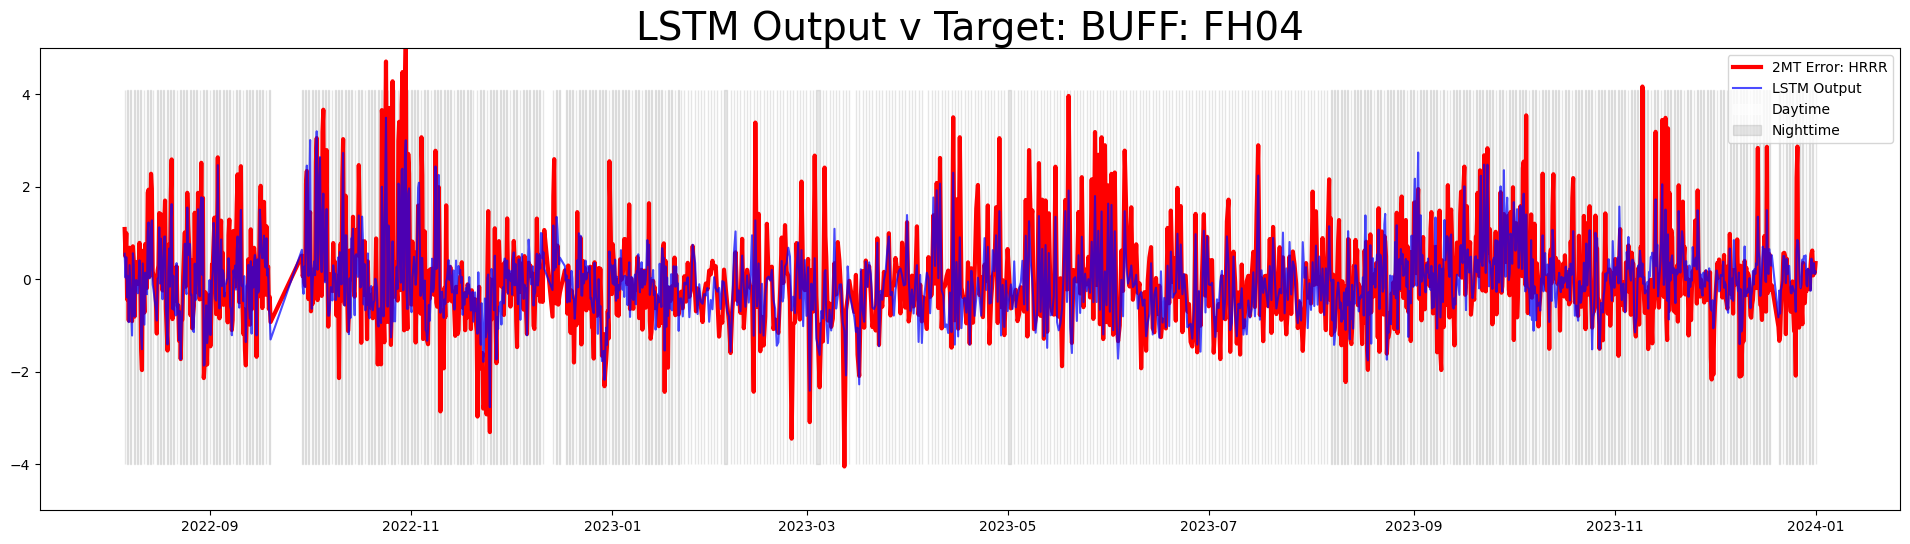

In [116]:
x = ml_output(df, 4, station)

In [117]:
full_df["Abs_err"] = df["diff"]

In [18]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [19]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [20]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

/tmp/tmp.rqc7rkuUP9/ipykernel_1834198/2351311710.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])


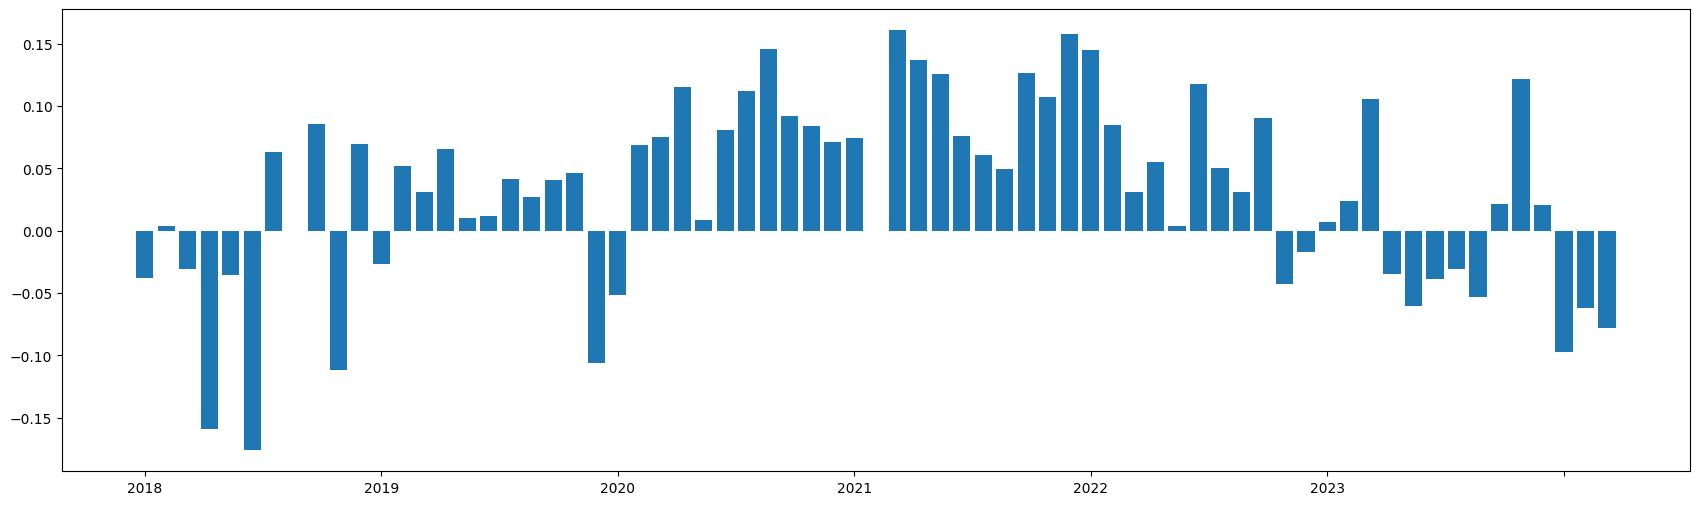

In [21]:
err_by_month = groupby_month(full_df, "Abs_err")

In [22]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

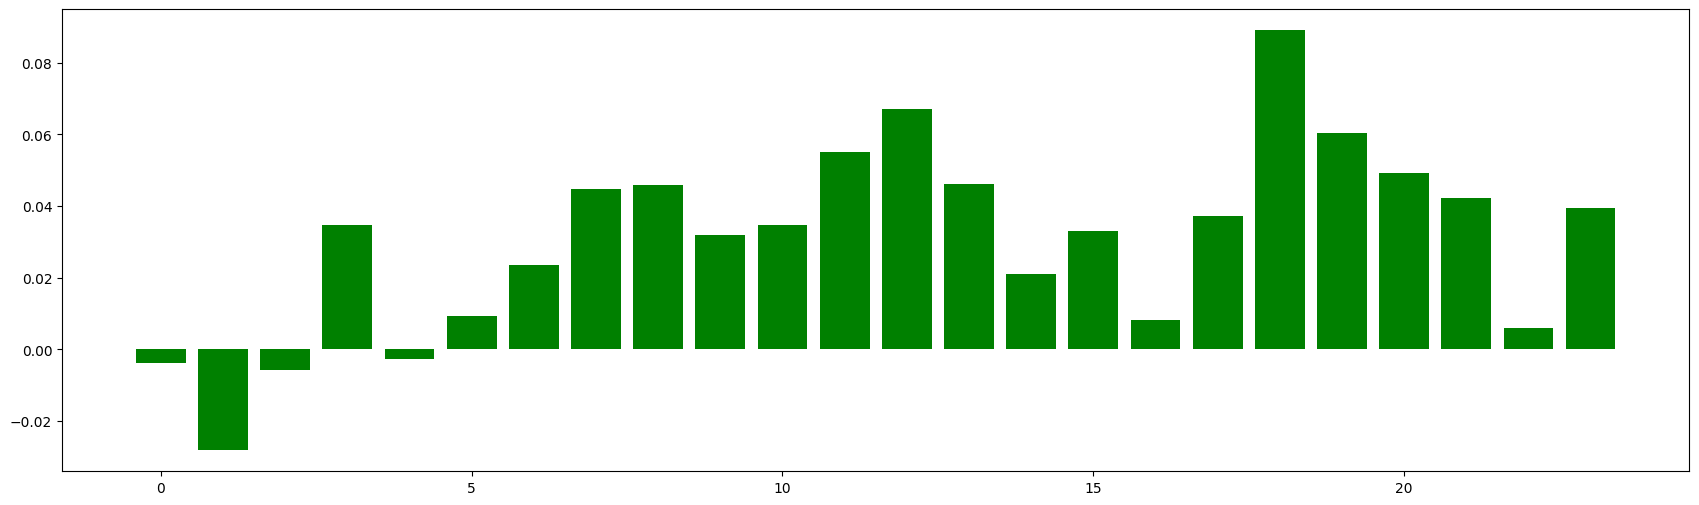

In [23]:
err_by_time = groupby_time(full_df, "Abs_err")

In [24]:
def myround(x, base):
    return base * round(x / base)

In [25]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [26]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [27]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(figsize=(21, 6), facecolor="slategrey", layout="compressed")
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [28]:
for k in full_df.keys():
    print(k)

valid_time
valid_time_cos
valid_time_sin
Abs_err


In [29]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [30]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

KeyError: 'tair_BKLN'

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 2.5)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

In [ ]:
full_df[f"pres_{station}"].mean()

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"new_tp_{station}", 2)

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 1.0)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)